In [31]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs,\
                                  pad_seqs_2step, pad_seqs_1step, calculate_output, onehot2seq 
from sklearn.metrics import r2_score

In [47]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def seq_acc(model, testdata, hidden_size, rep = 10, verbose = False):

    model.eval()
    trials = []
    accs = []
    for j, (x,y) in enumerate(testdata):
        for i in range(len(x)):
            hidden = torch.zeros(1, hidden_size)[0]
            for step in x[i]:
                hidden, y_hat = model.get_activations(step,hidden)
            correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
            accs.append(float(correct))
            curr_trial = onehot2seq(x)
            trials.append(curr_trial)
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
           
    return df.sort_values(by = 'acc',ascending = False)

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

In [8]:
# params

num_classes = 22
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20


# Trigrams: Addition

In [9]:
# def exp1(num_inputs):    
#     total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H']
#     all_syms = total_syms[:num_inputs]
    
#     # randomly select values for each input
#     cue_dict = {}
#     for s in all_syms:
#         cue_dict[s] = random.random()*10
#     # generate trials
#     p = pad_seqs_1step(all_syms, cue_dict)
#     train_sims = all_syms[1:]
#     trainseqs = generate_sequences(['+'], train_sims, len_seq = 1, cue_dict = cue_dict, init_values = train_sims)
#     testseqs = generate_sequences(['+'], all_syms, len_seq = 1, cue_dict = cue_dict, init_values = all_syms)
#     # randomly select a test trial to train non_primitive on
#     rand_test_trial = random.choice(trainseqs)
#     train_np = trainseqs + [rand_test_trial]
#     # remove any trian trials from test set
#     for val in train_np:
#             if val in testseqs:
#                 testseqs.remove(val)
                
#     # load data for primitive training
#     padtrain = p + pad_seqs_2step(trainseqs)
#     train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
#     trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
#     padtest = pad_seqs_2step(testseqs)
#     test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
#     testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
#     # run primitive training RNN
#     model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
#     model2 = copy.deepcopy(model)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
#     loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
#     df1 = test_preds(model, [testset], hidden_size)
#     df1['acc'] = (df1['label'].round(0) == df1['pred'].round(0)).astype(int)
    
#     # load data for non primitive trained RNN
#     padtrain = pad_seqs_2step(train_np)
#     train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
#     trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
#     # run
#     optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
#     loss2, acc2 = run_acc(model2,optimizer,criterion, trainset, [trainset, testset], epochs)
#     df2 = test_preds(model2, [testset], hidden_size, suffix = '_np')
    
#     # combine prediction differences between two RNNs
#     df = pd.merge(df1, df2, on='trial')
#     df['primitive_difference'] = df['pred'] - df['pred_np']
    
#     return {'cue_dict': cue_dict, 'df':df,\
#             'losses': loss1, 'accs': acc1,'model': model,\
#             'losses_np':loss2, 'accs_np': acc2, 'model_np': model2}

In [10]:
def exp1(num_inputs):    
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # generate trials
    p = pad_seqs_1step(all_syms, cue_dict)
    train_sims = all_syms[1:]
    trainseqs = generate_sequences(['+'], train_sims, len_seq = 1, cue_dict = cue_dict, init_values = train_sims)
    testseqs = generate_sequences(['+'], all_syms, len_seq = 1, cue_dict = cue_dict, init_values = all_syms)
    # randomly select a test trial to train non_primitive on
    # remove any trian trials from test set
    random_test = random.choice(testseqs)
    trainseqs_np = trainseqs + [random_test]
    for val in trainseqs_np:
        if val in testseqs:
            testseqs.remove(val)

    # load data for primitive training
    padtrain = p + pad_seqs_2step(trainseqs)
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtest = pad_seqs_2step(testseqs)
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    print('padtrain: ', padtrain)
    print('padtest: ', padtest)
    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    model2 = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
    
    padtrain = pad_seqs_2step(trainseqs_np)
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset_np = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    print('padtrain np: ', padtrain)
    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model2,optimizer,criterion, trainset_np, [trainset_np, testset], epochs)
    
    return {'cue_dict': cue_dict, 'testset': testset, 'losses': loss1, 'accs': acc1, 'model': model, \
           'losses_np': loss2, 'accs_np': acc2, 'model_np': model2,}

In [18]:
def exp4(num_inputs):    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    # generate trials
    p = pad_seqs_1step(all_syms, cue_dict)
    train_sims = all_syms[1:]
    trainseqs = generate_sequences(['+'], train_sims, len_seq = 1, cue_dict = cue_dict, init_values = train_sims)
    testseqs = generate_sequences(['+'], all_syms, len_seq = 1, cue_dict = cue_dict, init_values = all_syms)
    test2stepseqs = generate_sequences(['+'], all_syms, len_seq = 2, cue_dict = cue_dict, init_values = all_syms)
    # randomly select a test trial to train non_primitive on
    rand_trial = random.choice(testseqs)
    trainseqs_np = trainseqs + [rand_trial]
    # remove any trian trials from test set
    for val in trainseqs_np:
        if val in testseqs:
            testseqs.remove(val)
            
    # load data for primitive training
    padtrain = p + pad_seqs_2step(trainseqs)
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtrain_np = pad_seqs_2step(trainseqs_np)
    train_inputs = convert_seq2inputs(padtrain_np, num_classes=num_classes, seq_len=5)
    trainset_np = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtest = pad_seqs_2step(testseqs)
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    padtest2step = pad_seqs_2step(test2stepseqs)
    test_inputs = convert_seq2inputs(padtest2step, num_classes=num_classes, seq_len=5)
    test2step = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    model2 = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset, test2step], epochs)

    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model2,optimizer,criterion, trainset_np, [trainset_np, testset, test2step], epochs)

    return {'cue_dict': cue_dict, 'losses': loss1, 'accs': acc1, 'model': model, 'testset': testset,
           'losses_np': loss2, 'accs_np': acc2, 'model_np': model2}

## Exp 1

### how many inputs?
---

In [20]:
learningRate = 0.005
epochs = 3000
num_sims = 16

time:  0.8108345707257588


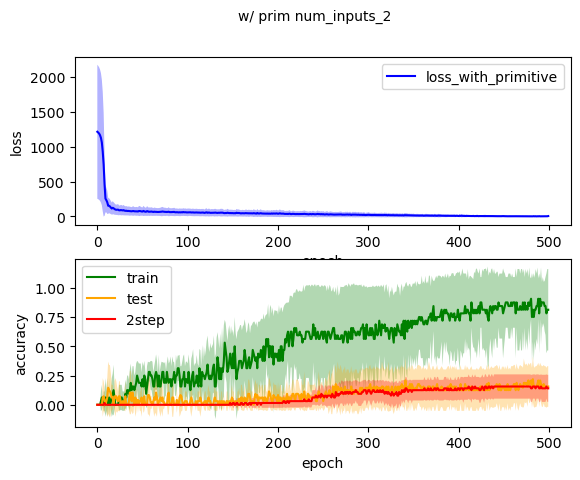

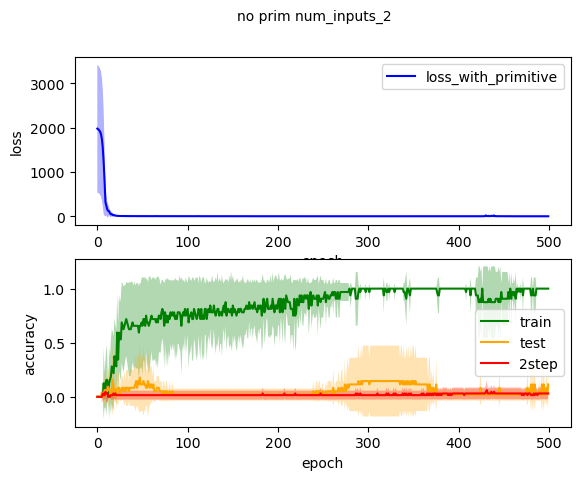

In [19]:
## 2 inputs with primitive training
t1 = time.time()
reses2 = Parallel(n_jobs = -1)(delayed(exp4)(2) for i in range(num_sims))

cuedicts_2 = [r['cue_dict'] for r in reses2]
all_tests2p = [r['testset'] for r in reses2]

all_losses2p = np.hstack([r['losses'] for r in reses2])
all_accs_train2p = np.array([r['accs'][:,0] for r in reses2]).T
all_accs_test2p = np.array([r['accs'][:,1] for r in reses2]).T
all_accs_test2step2p = np.array([r['accs'][:,2] for r in reses2]).T
all_mods2p = [r['model'] for r in reses2]

all_losses2np = np.hstack([r['losses_np'] for r in reses2])
all_accs_train2np = np.array([r['accs_np'][:,0] for r in reses2]).T
all_accs_test2np = np.array([r['accs_np'][:,1] for r in reses2]).T
all_accs_test2step2np = np.array([r['accs_np'][:,2] for r in reses2]).T
all_mods2np = [r['model_np'] for r in reses2]

plotNNs([all_losses2p], [all_accs_train2p, all_accs_test2p, all_accs_test2step2p], \
        ['train', 'test', '2step'], colors = ['green', 'orange', 'red'], title = 'w/ prim num_inputs_'+str(2), shift = 0)
plotNNs([all_losses2np], [all_accs_train2np, all_accs_test2np, all_accs_test2step2np], \
        ['train', 'test', '2step'], colors = ['green', 'orange', 'red'], title = 'no prim num_inputs_'+str(2), shift = 0)

t2 = time.time()
print('time: ', (t2-t1)/60)

time:  64.9854222337405


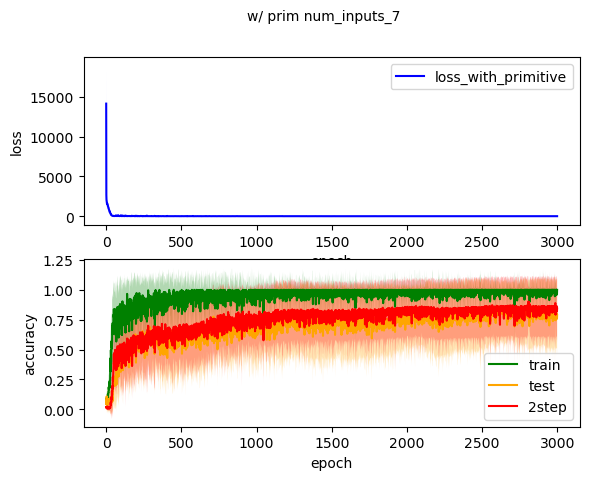

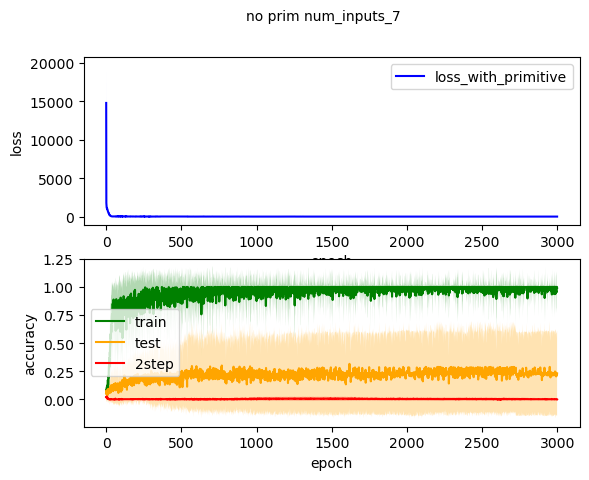

loss: 38.2 
loss: 0.5 
loss: 0.6 
loss: 0.0 
loss: 0.1 
loss: 0.1 
loss: 0.0 
loss: 3.9 
loss: 0.2 
loss: 14.9 
loss: 13.4 
loss: 0.9 
loss: 0.0 
loss: 0.1 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.3 
loss: 0.0 
loss: 0.1 
loss: 0.0 
loss: 0.6 
loss: 11.8 
loss: 0.4 
loss: 0.6 
loss: 0.0 
loss: 0.2 
loss: 0.2 
loss: 0.0 
loss: 0.1 
loss: 0.1 
loss: 0.4 


In [23]:
## 7 inputs with primitive training
t1 = time.time()
reses7 = Parallel(n_jobs = -1)(delayed(exp4)(7) for i in range(num_sims))

cuedicts_7 = [r['cue_dict'] for r in reses7]
all_tests7p = [r['testset'] for r in reses7]

all_losses7p = np.hstack([r['losses'] for r in reses7])
all_accs_train7p = np.array([r['accs'][:,0] for r in reses7]).T
all_accs_test7p = np.array([r['accs'][:,1] for r in reses7]).T
all_accs_test2step7p = np.array([r['accs'][:,2] for r in reses7]).T
all_mods7p = [r['model'] for r in reses7]

all_losses7np = np.hstack([r['losses_np'] for r in reses7])
all_accs_train7np = np.array([r['accs_np'][:,0] for r in reses7]).T
all_accs_test7np = np.array([r['accs_np'][:,1] for r in reses7]).T
all_accs_test2step7np = np.array([r['accs_np'][:,2] for r in reses7]).T
all_mods7np = [r['model_np'] for r in reses7]

plotNNs([all_losses7p], [all_accs_train7p, all_accs_test7p, all_accs_test2step7p], \
        ['train', 'test', '2step'], colors = ['green', 'orange', 'red'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([all_losses7np], [all_accs_train7np, all_accs_test7np, all_accs_test2step7np], \
        ['train', 'test', '2step'], colors = ['green', 'orange', 'red'], title = 'no prim num_inputs_'+str(7), shift = 0)

t7 = time.time()
print('time: ', (t7-t1)/60)

In [24]:
savedir = '../results/Lake/4_multiplesteps/'


with open(savedir+'reses7', 'wb') as f:
    pickle.dump(reses7, f)
    

In [26]:
tests1 = all_tests7p
tests2 = []

total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:7]

for i, cdict in enumerate(cuedicts_7):
    test2stepseqs = generate_sequences(['+'], all_syms, len_seq = 2, cue_dict = cdict, init_values = all_syms)
    padtest2step = pad_seqs_2step(test2stepseqs)
    test_inputs = convert_seq2inputs(padtest2step, num_classes=num_classes, seq_len=5)
    test2step = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    tests2.append(test2step)

Text(0.5, 1.0, '1 step test set with primitive training')

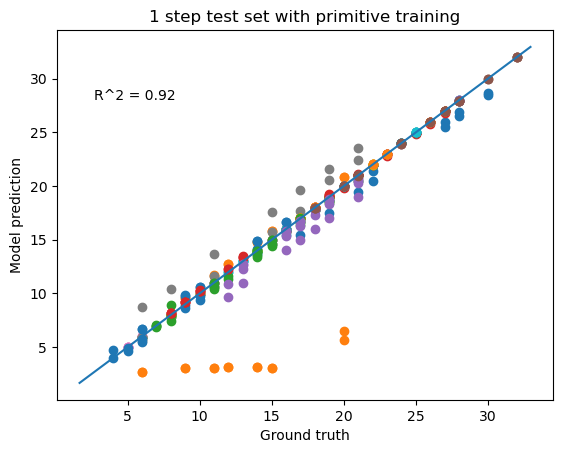

In [44]:
## plot p performance on 1 step

dfs = []
for i in range(len(all_mods7p)):
    df = test_preds(all_mods7p[i], [tests1[i]], hidden_size)
    dfs.append(df)
    all_dfs = pd.concat(dfs) 
preds, labs = all_dfs['pred'], all_dfs['label']
xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

for d in dfs:
    plt.scatter(d['label'], d['pred'])
plt.plot(xy,xy)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.annotate('R^2 = '+str(round(r2_score(all_dfs['pred'],all_dfs['label']), 2)),(np.min(preds),np.max(labs)-4))
plt.title('1 step test set with primitive training')

Text(0.5, 1.0, '2 step test set with primitive training')

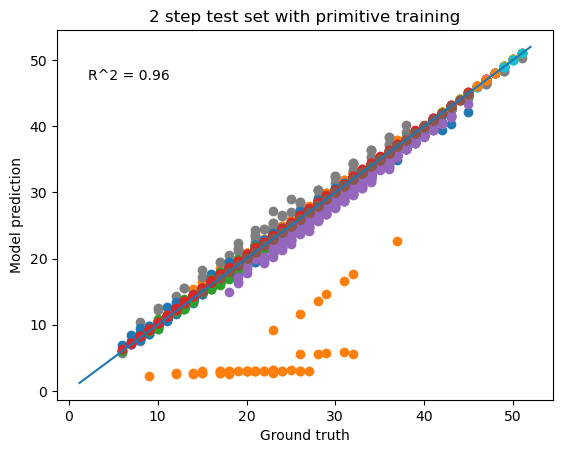

In [43]:
## plot p performance on 2 step

dfs = []
for i in range(len(all_mods7p)):
    df = test_preds(all_mods7p[i], [tests2[i]], hidden_size)
    dfs.append(df)
    all_dfs = pd.concat(dfs) 
preds, labs = all_dfs['pred'], all_dfs['label']
xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

for d in dfs:
    plt.scatter(d['label'], d['pred'])
plt.plot(xy,xy)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.annotate('R^2 = '+str(round(r2_score(all_dfs['pred'],all_dfs['label']), 2)),(np.min(preds),np.max(labs)-4))
plt.title('2 step test set with primitive training')

Text(0.5, 1.0, '2 step test set without primitive training')

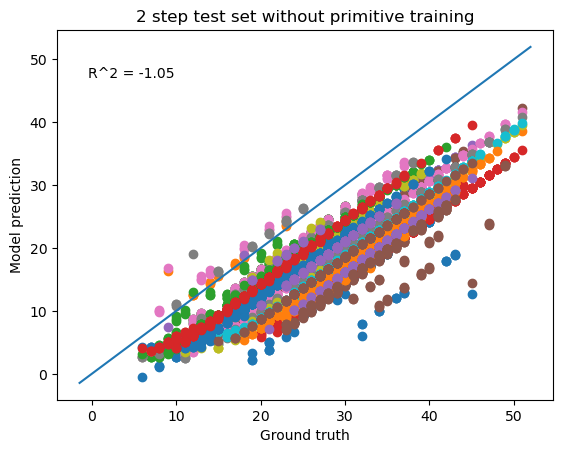

In [45]:
## plot p performance on 2 step

dfs = []
for i in range(len(all_mods7np)):
    df = test_preds(all_mods7np[i], [tests2[i]], hidden_size)
    dfs.append(df)
all_dfs = pd.concat(dfs) 
preds, labs = all_dfs['pred'], all_dfs['label']
xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

for d in dfs:
    plt.scatter(d['label'], d['pred'])
plt.plot(xy,xy)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.annotate('R^2 = '+str(round(r2_score(all_dfs['pred'],all_dfs['label']), 2)),(np.min(preds),np.max(labs)-4))
plt.title('2 step test set without primitive training')

Text(0.5, 1.0, '1 step test set without primitive training')

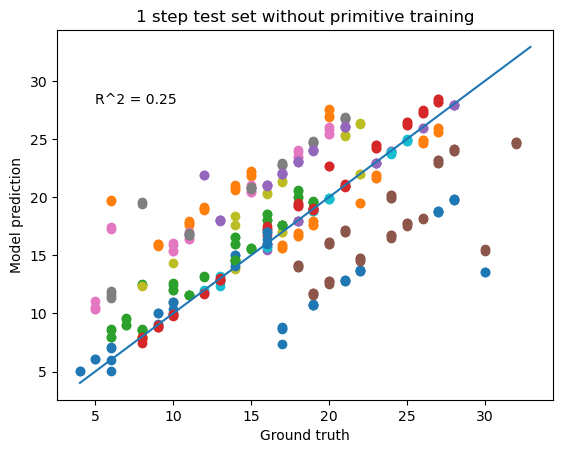

In [46]:
## plot p performance on 2 step

dfs = []
for i in range(len(all_mods7np)):
    df = test_preds(all_mods7np[i], [tests1[i]], hidden_size)
    dfs.append(df)
    all_dfs = pd.concat(dfs) 
preds, labs = all_dfs['pred'], all_dfs['label']
xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

for d in dfs:
    plt.scatter(d['label'], d['pred'])
plt.plot(xy,xy)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.annotate('R^2 = '+str(round(r2_score(all_dfs['pred'],all_dfs['label']), 2)),(np.min(preds),np.max(labs)-4))
plt.title('1 step test set without primitive training')

In [82]:
dfs_1step = []
for i in range(len(all_mods7np)):
    df1 = test_preds(all_mods7np[i], [tests1[i]], hidden_size, suffix = '_np')
    df2 = test_preds(all_mods7p[i], [tests1[i]], hidden_size)
    df = pd.merge(df1, df2, on = 'trial')
    df['pred_diff'] = df['pred'] - df['pred_np']
    df['err_p'] = df['pred'] - df['label']
    df['err_np'] = df['pred_np'] - df['label_np']
    dfs_1step.append(df)

dfs1 = pd.concat(dfs_1step)

    

In [101]:
df1p = []
df1np = []
df2p = []
df2np = []
for i in range(len(all_mods7np)):
    df1p.append(test_acc(all_mods7p[i], [tests1[i]], hidden_size)[0])
    df1np.append(test_acc(all_mods7np[i], [tests1[i]], hidden_size)[0])
    df2p.append(test_acc(all_mods7p[i], [tests2[i]], hidden_size)[0])
    df2np.append(test_acc(all_mods7np[i], [tests2[i]], hidden_size)[0])
    
    



{'whiskers': [<matplotlib.lines.Line2D at 0x7fb50190ffd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb50191e550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb50190fd30>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb50191ea90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb50191ed30>],
 'means': []}

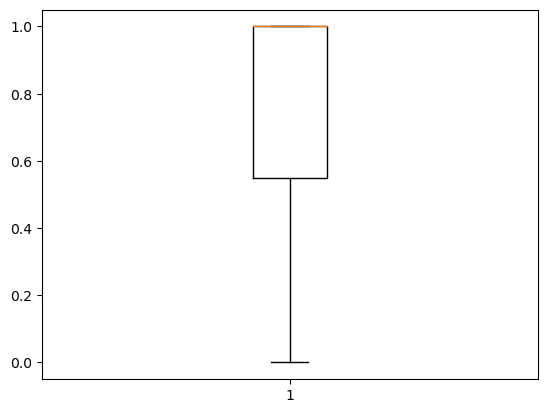

In [103]:
plt.boxplot(df1p)

In [105]:
np.mean(df1p)

0.7880608974358975

In [115]:
np.round([np.mean(df1p), np.mean(df2p)], 3)

array([0.788, 0.842])

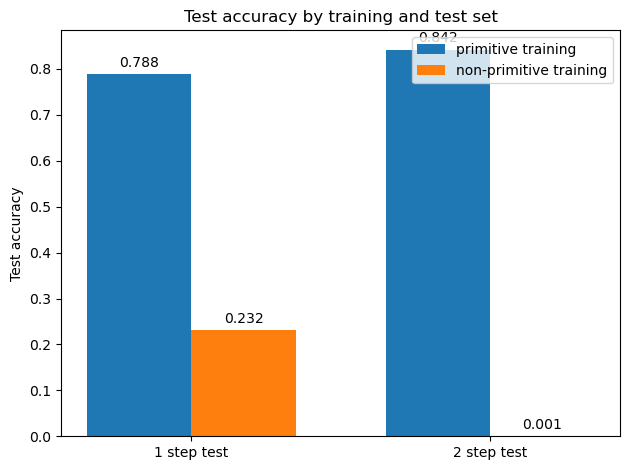

In [118]:

labels = ['1 step test', '2 step test']
p_means = np.round([np.mean(df1p), np.mean(df2p)],3)
np_means = np.round([np.mean(df1np), np.mean(df2np)],3)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, p_means, width, label='primitive training')
rects2 = ax.bar(x + width/2, np_means, width, label='non-primitive training')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Test accuracy')
ax.set_title('Test accuracy by training and test set')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


In [119]:
import seaborn as sns

In [120]:
df1p
df1np
df2p
df2np

[0.0,
 0.01749271137026239,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [127]:
training = 16*['primitive'] + 16*['non-primitive'] + 16*['primitive'] + 16*['non-primitive']
test_type = 32*['1 step'] + 32*['2 step']
accuracy = df1p + df1np + df2p + df2np

In [164]:
data = pd.DataFrame({'Training': training, 'Test type': test_type, 'Mean Accuracy': accuracy})

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
for index , row in sim.iterrows():
    ax.plot([row['x1'], row['x2']], [row['y1'],row['y2']], 
               label = row['label'], 
               color = row['color'])
ax.legend()
handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys())


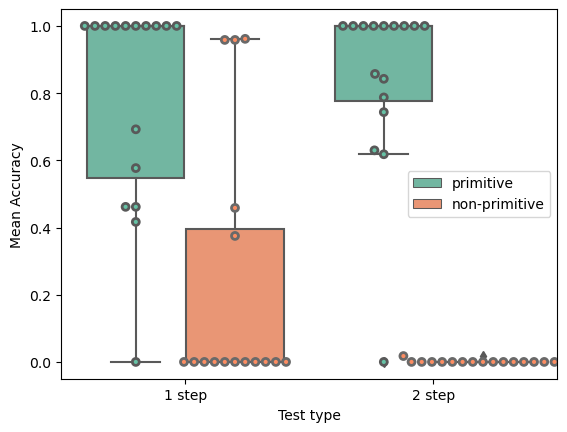

In [165]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.swarmplot(data=data, x='Test type', y="Mean Accuracy", hue="Training", dodge=True, palette="Set2", linewidth=2)

sns.boxplot(x = data['Test type'],
            y = data['Mean Accuracy'],
            hue = data['Training'],
            palette="Set2")
handles, labels = ax.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys())



<AxesSubplot: xlabel='Test type', ylabel='Accuracy'>

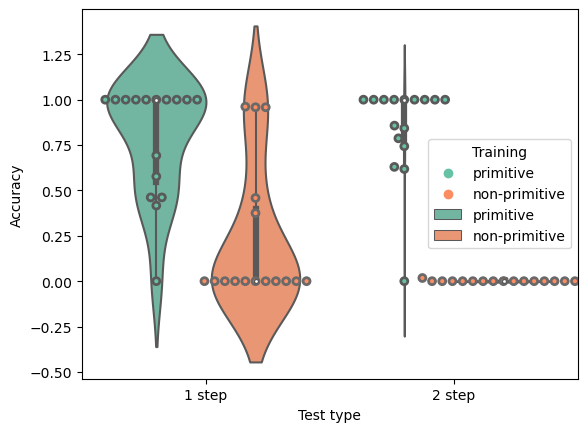

In [157]:
sns.swarmplot(data=data, x='Test type', y="Accuracy", hue="Training", dodge=True, palette="Set2", linewidth=2)
sns.violinplot(data=data, x='Test type', y="Accuracy", hue="Training", palette="Set2")

In [83]:
dfs1['pred_diff'] = dfs1['pred'] - dfs1['pred_np']

In [84]:
dfs1

,trial,label_np,pred_np,label,pred,pred_diff,err_p,err_np
0,"['B', '+', 'X', '+', 'A']",19.0,10.792185,19.0,17.473974,6.681789,-1.526026,-8.207815
1,"['A', '+', 'D', '+', 'X']",27.0,18.704273,27.0,26.993719,8.289446,-0.006281,-8.295727
2,"['A', '+', 'C', '+', 'X']",22.0,13.668837,22.0,21.994352,8.325516,-0.005648,-8.331163
3,"['G', '+', 'X', '+', 'A']",21.0,12.837110,21.0,19.480593,6.643483,-1.519407,-8.162890
4,"['A', '+', 'F', '+', 'X']",28.0,19.730213,28.0,27.992838,8.262625,-0.007162,-8.269787
...,...,...,...,...,...,...,...,...
21,"['A', '+', 'C', '+', 'X']",21.0,17.003590,21.0,20.984947,3.981358,-0.015053,-3.996410
22,"['A', '+', 'F', '+', 'X']",27.0,22.968212,27.0,26.968071,3.999859,-0.031929,-4.031788
23,"['A', '+', 'X', '+', 'G']",18.0,14.001769,18.0,17.963825,3.962056,-0.036175,-3.998231
24,"['A', '+', 'B', '+', 'X']",20.0,15.988647,20.0,19.976160,3.987514,-0.023840,-4.011353


(array([  4.,   0.,  32.,  18.,  38., 172.,  40.,  96.,   2.,   6.]),
 array([-16.45095634, -13.42795029, -10.40494423,  -7.38193817,
         -4.35893211,  -1.33592606,   1.68708   ,   4.71008606,
          7.73309212,  10.75609818,  13.77910423]),
 <BarContainer object of 10 artists>)

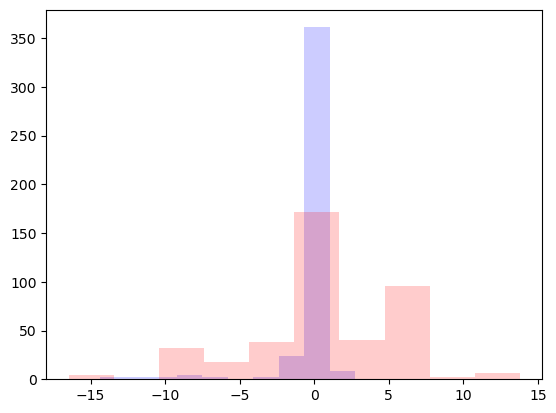

In [93]:
plt.hist(dfs1['err_p'], color = 'blue', alpha = 0.2)
plt.hist(dfs1['err_np'], color = 'red', alpha = 0.2)

In [65]:
pd.merge(dfs1np, dfs1p, on = 'trial', how = 'inner')

,trial,label,pred,label_np,pred_np
0,"['C', '+', 'X', '+', 'A']",22.0,13.729425,22.0,20.482925
1,"['C', '+', 'X', '+', 'A']",22.0,13.729425,20.0,20.882713
2,"['C', '+', 'X', '+', 'A']",22.0,13.729425,10.0,9.985280
3,"['C', '+', 'X', '+', 'A']",22.0,13.729425,26.0,25.828152
4,"['C', '+', 'X', '+', 'A']",22.0,13.729425,24.0,23.979910
...,...,...,...,...,...
6403,"['D', '+', 'A', '+', 'X']",28.0,24.148167,26.0,26.017281
6404,"['D', '+', 'A', '+', 'X']",28.0,24.148167,19.0,18.625410
6405,"['D', '+', 'A', '+', 'X']",28.0,24.148167,21.0,21.079851
6406,"['D', '+', 'A', '+', 'X']",28.0,24.148167,17.0,16.302326


In [50]:
trail_accs = []
for i in range(len(all_mods7np)):
    trail_acc = seq_acc(all_mods7p[i], tests2[i], hidden_size)
    trail_accs.append(trail_acc)


In [51]:
trail_accs

[                         trial  acc
 0    ['F', '+', 'F', '+', 'D']  1.0
 214  ['B', '+', 'B', '+', 'D']  1.0
 222  ['G', '+', 'F', '+', 'F']  1.0
 221  ['F', '+', 'E', '+', 'D']  1.0
 220  ['G', '+', 'F', '+', 'B']  1.0
 ..                         ...  ...
 53   ['C', '+', 'A', '+', 'E']  0.0
 55   ['C', '+', 'A', '+', 'C']  0.0
 270  ['F', '+', 'A', '+', 'E']  0.0
 267  ['A', '+', 'A', '+', 'C']  0.0
 154  ['C', '+', 'A', '+', 'B']  0.0
 
 [343 rows x 2 columns],
                          trial  acc
 342  ['G', '+', 'B', '+', 'B']  1.0
 294  ['G', '+', 'F', '+', 'C']  1.0
 278  ['D', '+', 'G', '+', 'B']  1.0
 148  ['C', '+', 'D', '+', 'D']  1.0
 149  ['E', '+', 'F', '+', 'D']  1.0
 ..                         ...  ...
 163  ['A', '+', 'B', '+', 'E']  0.0
 165  ['A', '+', 'F', '+', 'C']  0.0
 170  ['A', '+', 'C', '+', 'F']  0.0
 173  ['C', '+', 'A', '+', 'B']  0.0
 171  ['E', '+', 'A', '+', 'E']  0.0
 
 [343 rows x 2 columns],
                          trial  acc
 0    ['G', '+', 'D',

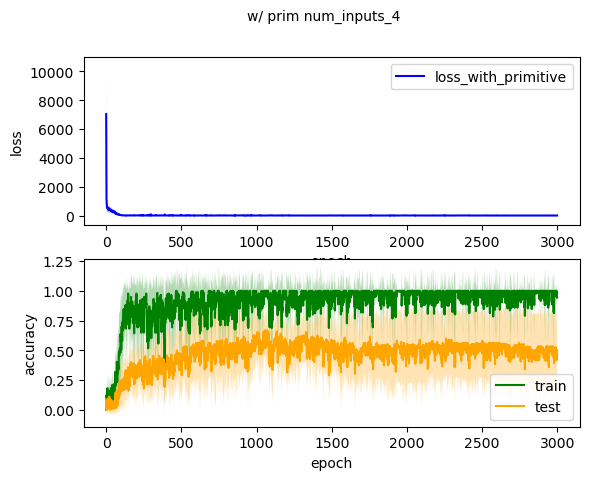

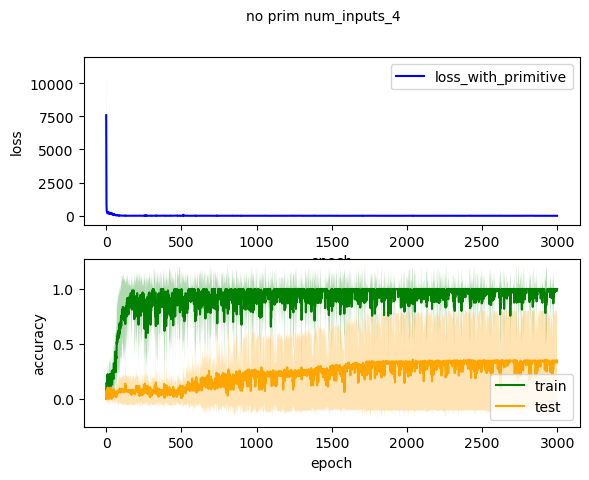

In [52]:
cuedicts_4 = [r['cue_dict'] for r in reses4]
all_tests4p = [r['testset'] for r in reses4]

all_losses4p = np.hstack([r['losses'] for r in reses4])
all_accs_train4p = np.array([r['accs'][:,0] for r in reses4]).T
all_accs_test4p = np.array([r['accs'][:,1] for r in reses4]).T
all_mods4p = [r['model'] for r in reses4]

all_losses4np = np.hstack([r['losses_np'] for r in reses4])
all_accs_train4np = np.array([r['accs_np'][:,0] for r in reses4]).T
all_accs_test4np = np.array([r['accs_np'][:,1] for r in reses4]).T
all_mods4np = [r['model_np'] for r in reses4]

plotNNs([all_losses4p], [all_accs_train4p, all_accs_test4p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(4), shift = 0)
plotNNs([all_losses4np], [all_accs_train4np, all_accs_test4np], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(4), shift = 0)



time:  0.2715149998664856


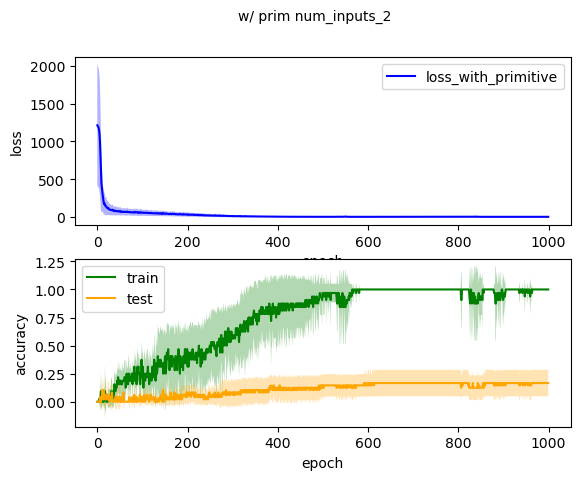

In [37]:
## 2 inputs with primitive training
t1 = time.time()
reses2 = Parallel(n_jobs = -1)(delayed(exp1)(2) for i in range(num_sims))

cuedicts_2 = [r['cue_dict'] for r in reses2]
all_tests2p = [r['testset'] for r in reses2]

all_losses2p = np.hstack([r['losses'] for r in reses2])
all_accs_train2p = np.array([r['accs'][:,0] for r in reses2]).T
all_accs_test2p = np.array([r['accs'][:,1] for r in reses2]).T
all_mods2p = [r['model'] for r in reses2]

# all_losses2np = np.hstack([r['losses_np'] for r in reses2])
# all_accs_train2np = np.array([r['accs_np'][:,0] for r in reses2]).T
# all_accs_test2np = np.array([r['accs_np'][:,1] for r in reses2]).T
# all_mods2np = [r['model_np'] for r in reses2]

plotNNs([all_losses2p], [all_accs_train2p, all_accs_test2p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(2), shift = 0)
# plotNNs([all_losses2np], [all_accs_train2np, all_accs_test2np], \
#         ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(2), shift = 0)

t2 = time.time()
print('time: ', (t2-t1)/60)

time:  4.771969552834829


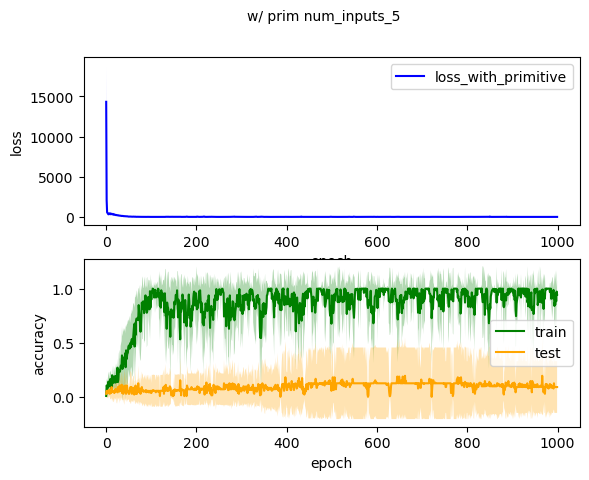

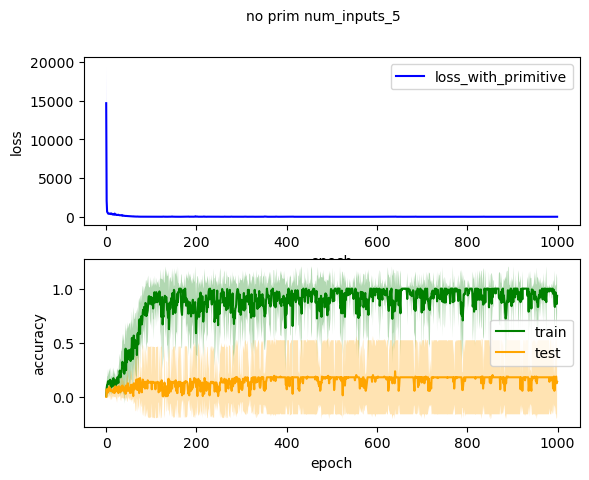

In [11]:
## 5 inputs with primitive training
t1 = time.time()
reses5 = Parallel(n_jobs = -1)(delayed(exp1)(5) for i in range(num_sims))

cuedicts_5 = [r['cue_dict'] for r in reses5]
all_tests5p = [r['testset'] for r in reses5]

all_losses5p = np.hstack([r['losses'] for r in reses5])
all_accs_train5p = np.array([r['accs'][:,0] for r in reses5]).T
all_accs_test5p = np.array([r['accs'][:,1] for r in reses5]).T
all_mods5p = [r['model'] for r in reses5]

all_losses5np = np.hstack([r['losses_np'] for r in reses5])
all_accs_train5np = np.array([r['accs_np'][:,0] for r in reses5]).T
all_accs_test5np = np.array([r['accs_np'][:,1] for r in reses5]).T
all_mods5np = [r['model_np'] for r in reses5]

plotNNs([all_losses5p], [all_accs_train5p, all_accs_test5p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(5), shift = 0)
plotNNs([all_losses5np], [all_accs_train5np, all_accs_test5np], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(5), shift = 0)

t5 = time.time()
print('time: ', (t5-t1)/60)

time:  7.203330564498901


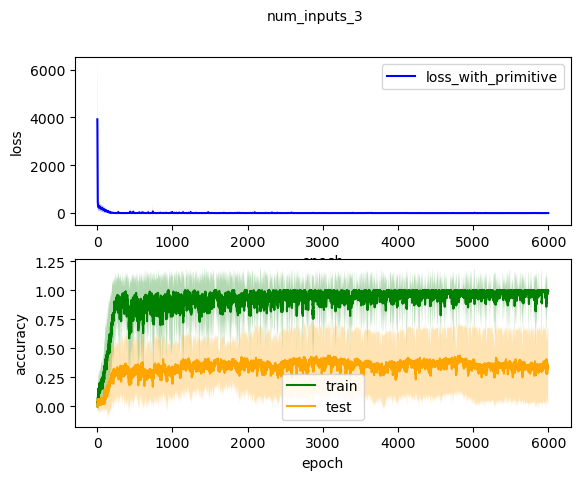

In [49]:
## 3 inputs with primitive training
t1 = time.time()
reses3 = Parallel(n_jobs = -1)(delayed(exp1)(3) for i in range(num_sims))

cuedicts_3 = [r['cue_dict'] for r in reses3]
all_losses3p = np.hstack([r['losses'] for r in reses3])
all_accs_train3p = np.array([r['accs'][:,0] for r in reses3]).T
all_accs_test3p = np.array([r['accs'][:,1] for r in reses3]).T
all_mods3p = [r['model'] for r in reses3]
all_tests3p = [r['testset'] for r in reses3]

plotNNs([all_losses3p], [all_accs_train3p, all_accs_test3p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(3), shift = 0)
t2 = time.time()
print('time: ', (t2-t1)/60)

time:  10.8571307182312


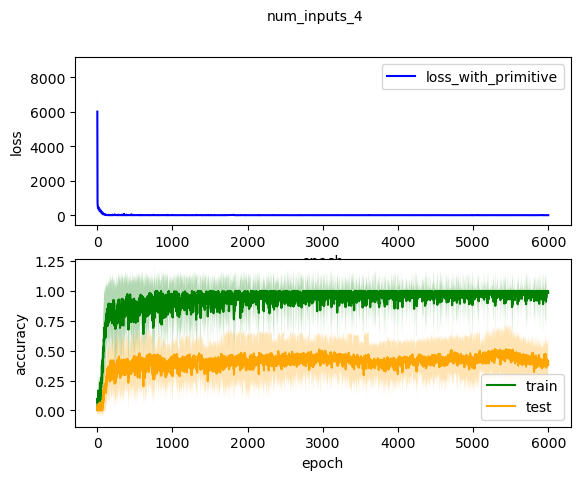

In [50]:
## 4 inputs with primitive training
t1 = time.time()
reses4 = Parallel(n_jobs = -1)(delayed(exp1)(4) for i in range(num_sims))

cuedicts_4 = [r['cue_dict'] for r in reses4]
all_losses4p = np.hstack([r['losses'] for r in reses4])
all_accs_train4p = np.array([r['accs'][:,0] for r in reses4]).T
all_accs_test4p = np.array([r['accs'][:,1] for r in reses4]).T
all_mods4p = [r['model'] for r in reses4]
all_tests4p = [r['testset'] for r in reses4]

plotNNs([all_losses4p], [all_accs_train4p, all_accs_test4p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(4), shift = 0)
t4 = time.time()
print('time: ', (t4-t1)/60)

time:  16.85858073234558


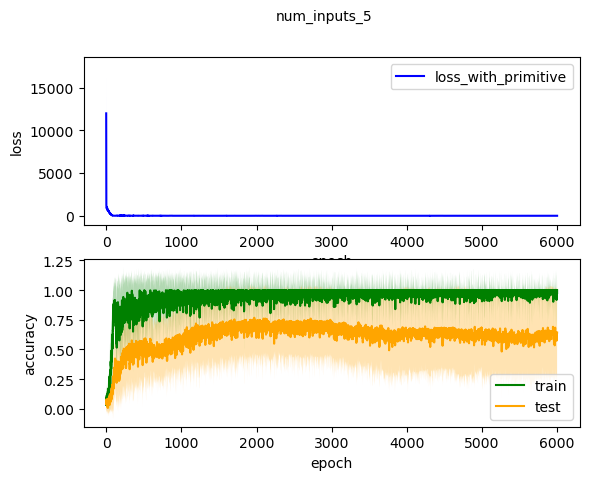

In [51]:
## 5 inputs with primitive training
t1 = time.time()
reses5 = Parallel(n_jobs = -1)(delayed(exp1)(5) for i in range(num_sims))

cuedicts_5 = [r['cue_dict'] for r in reses5]
all_losses5p = np.hstack([r['losses'] for r in reses5])
all_accs_train5p = np.array([r['accs'][:,0] for r in reses5]).T
all_accs_test5p = np.array([r['accs'][:,1] for r in reses5]).T
all_mods5p = [r['model'] for r in reses5]
all_tests5p = [r['testset'] for r in reses5]

plotNNs([all_losses5p], [all_accs_train5p, all_accs_test5p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(5), shift = 0)
t5 = time.time()
print('time: ', (t5-t1)/60)

time:  23.906100237369536


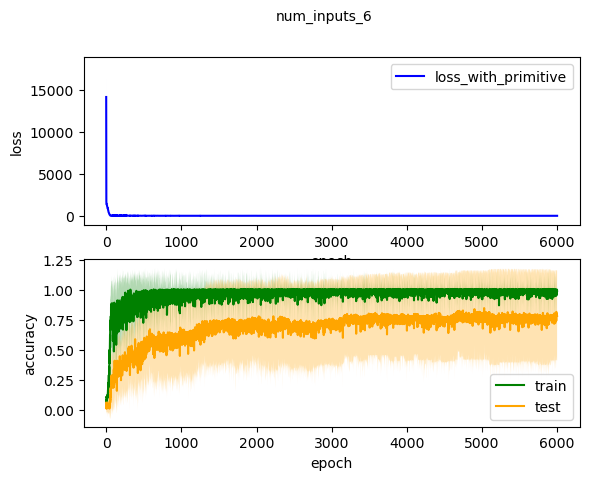

In [52]:
## 6 inputs with primitive training
t1 = time.time()
reses6 = Parallel(n_jobs = -1)(delayed(exp1)(6) for i in range(num_sims))

cuedicts_6 = [r['cue_dict'] for r in reses6]
all_losses6p = np.hstack([r['losses'] for r in reses6])
all_accs_train6p = np.array([r['accs'][:,0] for r in reses6]).T
all_accs_test6p = np.array([r['accs'][:,1] for r in reses6]).T
all_mods6p = [r['model'] for r in reses6]
all_tests6p = [r['testset'] for r in reses6]

plotNNs([all_losses6p], [all_accs_train6p, all_accs_test6p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(6), shift = 0)
t6 = time.time()
print('time: ', (t6-t1)/60)

time:  32.63038291533788


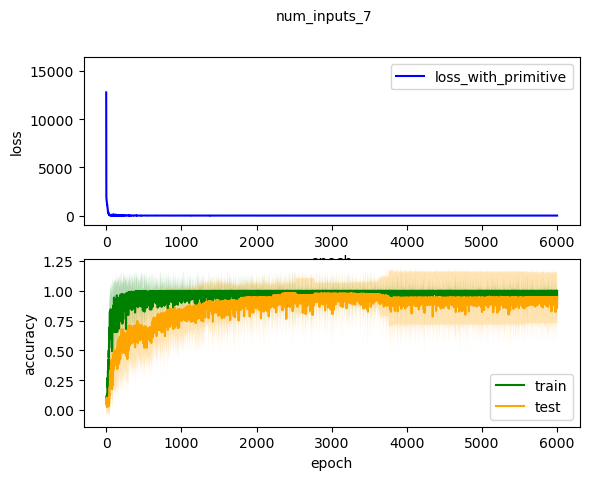

In [53]:
## 7 inputs with primitive training
t1 = time.time()
reses7 = Parallel(n_jobs = -1)(delayed(exp1)(7) for i in range(num_sims))

cuedicts_7 = [r['cue_dict'] for r in reses7]
all_losses7p = np.hstack([r['losses'] for r in reses7])
all_accs_train7p = np.array([r['accs'][:,0] for r in reses7]).T
all_accs_test7p = np.array([r['accs'][:,1] for r in reses7]).T
all_mods7p = [r['model'] for r in reses7]
all_tests7p = [r['testset'] for r in reses7]

plotNNs([all_losses7p], [all_accs_train7p, all_accs_test7p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(7), shift = 0)
t7 = time.time()
print('time: ', (t7-t1)/60)

In [ ]:
## 8 inputs with primitive training
t1 = time.time()
reses8 = Parallel(n_jobs = -1)(delayed(exp1)(8) for i in range(num_sims))

cuedicts_8 = [r['cue_dict'] for r in reses8]
all_losses8p = np.hstack([r['losses'] for r in reses8])
all_accs_train8p = np.array([r['accs'][:,0] for r in reses8]).T
all_accs_test8p = np.array([r['accs'][:,1] for r in reses8]).T
all_mods8p = [r['model'] for r in reses8]
all_tests8p = [r['testset'] for r in reses8]

plotNNs([all_losses8p], [all_accs_train8p, all_accs_test8p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(8), shift = 0)
t8 = time.time()
print('time: ', (t8-t1)/60)

In [ ]:
savedir = '../results/Lake/1_addition/'

for i in range(8):
    with open(savedir+'reses'+str(i+1), 'wb') as f:
        pickle.dump(eval('reses'+ str(i+1)), f)
    

## TODO:
save objects
plot scatter points correlations
plot r2 against number of inputs
look at RNNs accuracy trial - e.g how many fully accurate?

In [ ]:
from sklearn.metrics import r2_score

modlist = all_mods6p
testlist = all_tests6p
dfs = []
for i in range(len(modlist)):
    df = test_preds(modlist[i], [testlist[i]], hidden_size)
    dfs.append(df)
all_dfs = pd.concat(dfs) 
preds, labs = all_dfs['pred'], all_dfs['label']
xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
for d in dfs:
    plt.scatter(d['pred'], d['label'])
plt.plot(xy,xy)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.annotate('R^2 = '+str(round(r2_score(all_dfs['pred'],all_dfs['label']), 2)),(np.min(preds),np.max(labs)))

In [ ]:
## 9 inputs with primitive training
t1 = time.time()
reses9 = Parallel(n_jobs = -1)(delayed(exp1)(9) for i in range(num_sims))

cuedicts_9 = [r['cue_dict'] for r in reses9]
all_losses9p = np.hstack([r['losses'] for r in reses9])
all_accs_train9p = np.array([r['accs'][:,0] for r in reses9]).T
all_accs_test9p = np.array([r['accs'][:,1] for r in reses9]).T
all_mods9p = [r['model'] for r in reses9]
all_tests9p = [r['testset'] for r in reses9]

plotNNs([all_losses9p], [all_accs_train9p, all_accs_test9p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(9), shift = 0)
t9 = time.time()
print('time: ', (t9-t1)/60)

time:  2.5250228802363077


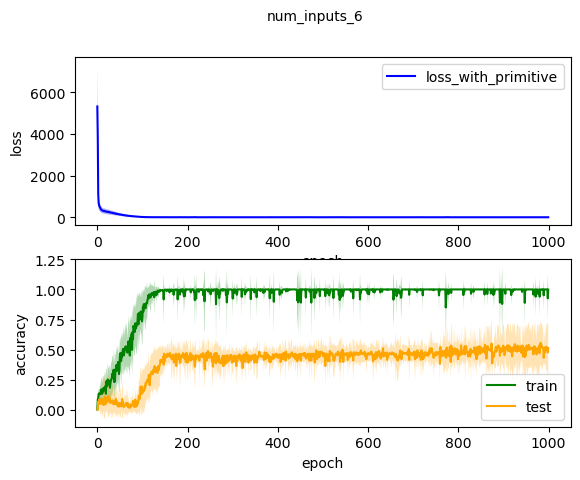

In [92]:
## 6 inputs with primitive training
t1 = time.time()
reses6 = Parallel(n_jobs = -1)(delayed(exp1)(6) for i in range(num_sims))

cuedicts_6 = [r['cue_dict'] for r in reses6]
all_losses6p = np.hstack([r['losses'] for r in reses6])
all_accs_train6p = np.array([r['accs'][:,0] for r in reses6]).T
all_accs_test6p = np.array([r['accs'][:,1] for r in reses6]).T
all_mods6p = [r['model'] for r in reses6]

plotNNs([all_losses6p], [all_accs_train6p, all_accs_test6p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(6), shift = 0)
t2 = time.time()
print('time: ', (t2-t1)/60)

time:  2.7443034489949545


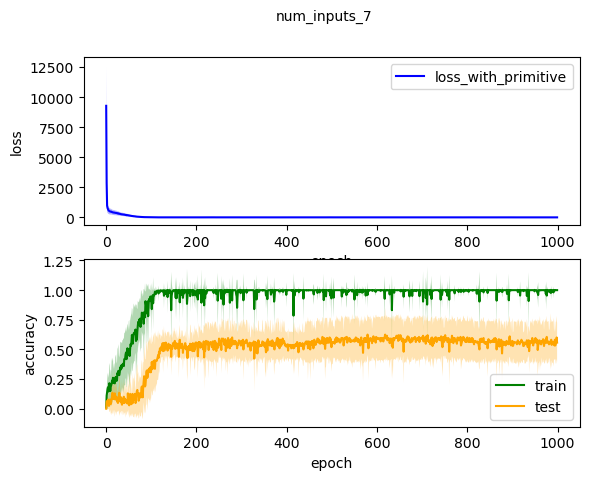

In [93]:
## 7 inputs with primitive training
t1 = time.time()
reses7 = Parallel(n_jobs = -1)(delayed(exp1)(7) for i in range(num_sims))

cuedicts_7 = [r['cue_dict'] for r in reses7]
all_losses7p = np.hstack([r['losses'] for r in reses7])
all_accs_train7p = np.array([r['accs'][:,0] for r in reses7]).T
all_accs_test7p = np.array([r['accs'][:,1] for r in reses7]).T
all_mods7p = [r['model'] for r in reses7]

plotNNs([all_losses7p], [all_accs_train7p, all_accs_test7p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(7), shift = 0)
t2 = time.time()
print('time: ', (t2-t1)/60)

Text(3.7200706005096436, 30.0, 'R^2 = 0.96')

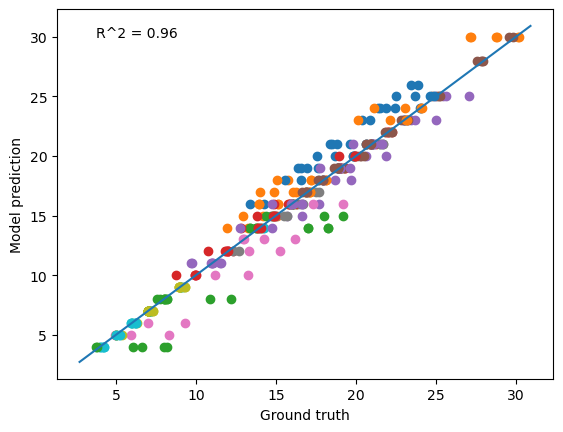

In [46]:
epochs = 6000

modlist = all_mods6p
testlist = all_tests6p
dfs = []
for i in range(len(modlist)):
    df = test_preds(modlist[i], [testlist[i]], hidden_size)
    dfs.append(df)
all_dfs = pd.concat(dfs) 
preds, labs = all_dfs['pred'], all_dfs['label']
xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
for d in dfs:
    plt.scatter(d['pred'], d['label'])
plt.plot(xy,xy)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.annotate('R^2 = '+str(round(r2_score(all_dfs['pred'],all_dfs['label']), 2)),(np.min(preds),np.max(labs)))

time:  73.09213945070903


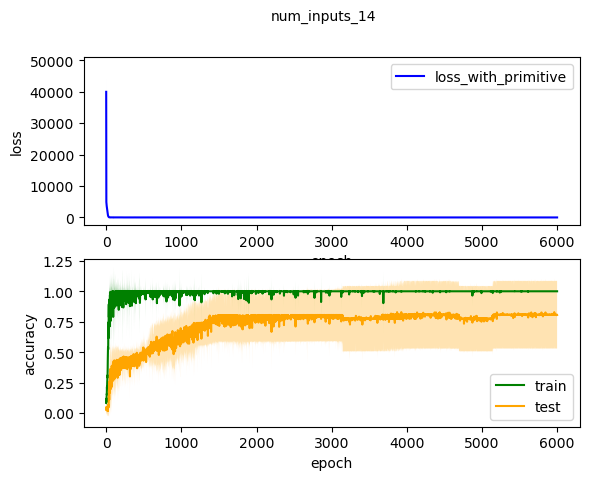

loss: 2555.9 
loss: 11.9 
loss: 0.0 
loss: 2488.9 
loss: 0.1 
loss: 0.5 
loss: 4609.6 
loss: 0.5 
loss: 3.1 
loss: 4930.0 
loss: 1.2 
loss: 0.0 
loss: 3446.7 
loss: 3.4 
loss: 0.1 
loss: 4054.0 
loss: 9.5 
loss: 0.1 
loss: 4120.3 
loss: 12.4 
loss: 0.8 
loss: 3879.5 
loss: 1.9 
loss: 0.1 


In [17]:
## 14 inputs with primitive training
t1 = time.time()
reses14 = Parallel(n_jobs = -1)(delayed(exp1)(14) for i in range(num_sims))

cuedicts_14 = [r['cue_dict'] for r in reses14]
all_losses14p = np.hstack([r['losses'] for r in reses14])
all_accs_train14p = np.array([r['accs'][:,0] for r in reses14]).T
all_accs_test14p = np.array([r['accs'][:,1] for r in reses14]).T
all_mods14p = [r['model'] for r in reses14]
all_tests14p = [r['testset'] for r in reses14]

plotNNs([all_losses14p], [all_accs_train14p, all_accs_test14p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(14), shift = 0)
t2 = time.time()
print('time: ', (t2-t1)/60)

time:  38.8723984281222


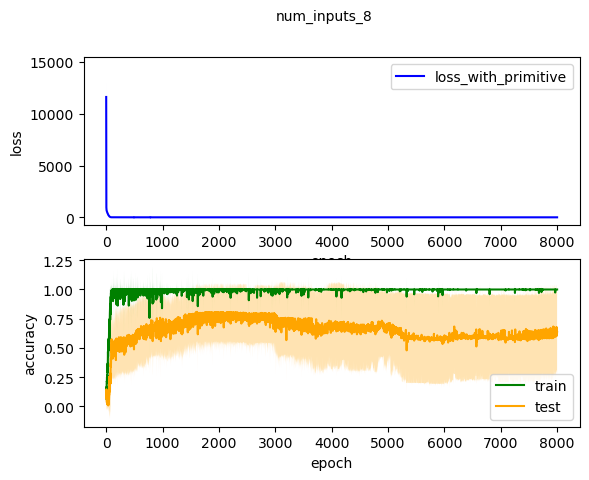

In [98]:
epochs = 8000
batchsize = 1

## 8 inputs with primitive training
t1 = time.time()
reses8 = Parallel(n_jobs = -1)(delayed(exp1)(8) for i in range(num_sims))

cuedicts_8 = [r['cue_dict'] for r in reses8]
all_losses8p = np.hstack([r['losses'] for r in reses8])
all_accs_train8p = np.array([r['accs'][:,0] for r in reses8]).T
all_accs_test8p = np.array([r['accs'][:,1] for r in reses8]).T
all_mods8p = [r['model'] for r in reses8]

plotNNs([all_losses8p], [all_accs_train8p, all_accs_test8p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(8), shift = 0)
t2 = time.time()
print('time: ', (t2-t1)/60)

time:  20.264828650156655


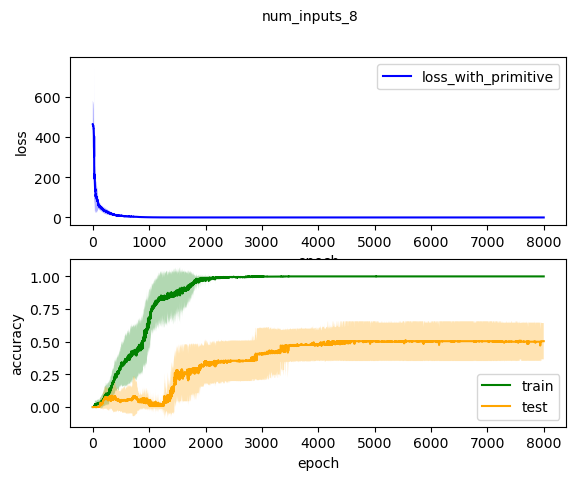

loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 


In [97]:
epochs = 8000
batchsize = 40

## 8 inputs with primitive training
t1 = time.time()
reses8 = Parallel(n_jobs = -1)(delayed(exp1)(8) for i in range(num_sims))

cuedicts_8 = [r['cue_dict'] for r in reses8]
all_losses8p = np.hstack([r['losses'] for r in reses8])
all_accs_train8p = np.array([r['accs'][:,0] for r in reses8]).T
all_accs_test8p = np.array([r['accs'][:,1] for r in reses8]).T
all_mods8p = [r['model'] for r in reses8]

plotNNs([all_losses8p], [all_accs_train8p, all_accs_test8p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(8), shift = 0)
t2 = time.time()
print('time: ', (t2-t1)/60)

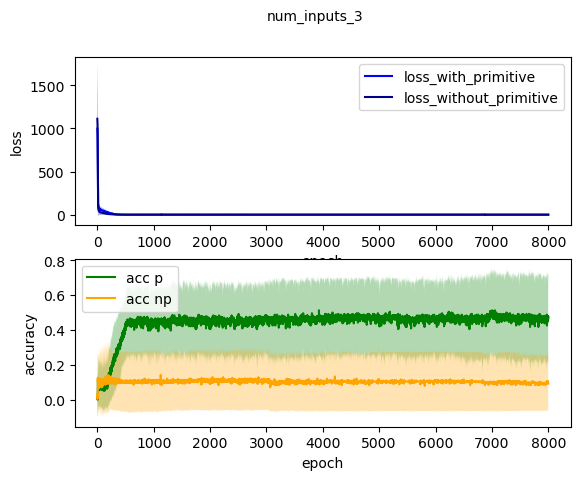

In [47]:
## 3 inputs with primitive training
reses3 = Parallel(n_jobs = -1)(delayed(exp1)(3) for i in range(num_sims))

cuedicts_3 = [r['cue_dict'] for r in reses3]
all_dfs3 = [r['df'] for r in reses3]

all_losses3p = np.hstack([r['losses'] for r in reses3])
all_accs_train3p = np.array([r['accs'][:,0] for r in reses3]).T
all_accs_test3p = np.array([r['accs'][:,1] for r in reses3]).T
all_mods3p = [r['model'] for r in reses3]

all_losses3np = np.hstack([r['losses_np'] for r in reses3])
all_accs_train3np = np.array([r['accs_np'][:,0] for r in reses3]).T
all_accs_test3np = np.array([r['accs_np'][:,1] for r in reses3]).T
all_mods3np = [r['model_np'] for r in reses3]

plotNNs([all_losses3p, all_losses3np], [all_accs_test3p, all_accs_test3np], \
        ['acc p', 'acc np'], colors = ['green', 'orange'], title = 'num_inputs_'+str(3), shift = 0)

epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700
epoch:  6800
epoch:  6900
epoch:  7000
epoch:  7100
epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600
epoch:  770

epoch:  7100epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700
epoch:  6800
epoch:  6900
epoch:  7000
epoch:  7100
epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600

epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700
epoch:  6800
epoch:  6900
epoch:  7000
epoch:  7100
epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600
epoch:  7700
epoch:  7800
epoch:  7900
loss: 0.0 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800


epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700
epoch:  6800
epoch:  6900
epoch:  7000
epoch:  7100
epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600
epoch:  7700
epoch:  7800
epoch:  7900
loss: 0.0 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300


epoch:  7600
epoch:  7700
epoch:  7800
epoch:  7900
loss: 0.4 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700
epoch:  6800
epoch:  6900
epoch:  7000
epoch:  7100epoch:  0
epoc

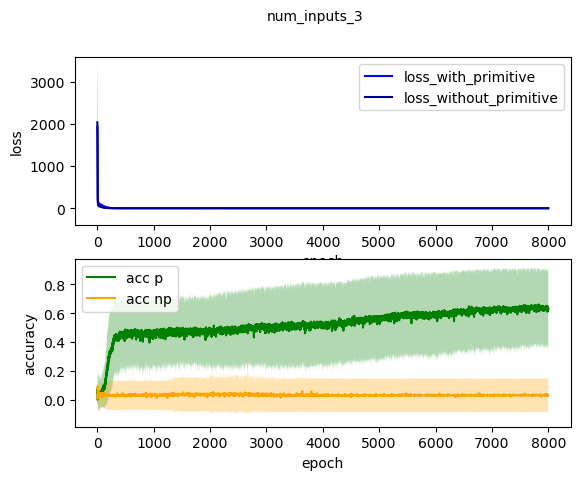

In [48]:
## 4 inputs with primitive training
reses4 = Parallel(n_jobs = -1)(delayed(exp1)(4) for i in range(num_sims))

cuedicts_4 = [r['cue_dict'] for r in reses4]
all_dfs4 = [r['df'] for r in reses4]

all_losses4p = np.hstack([r['losses'] for r in reses4])
all_accs_train4p = np.array([r['accs'][:,0] for r in reses4]).T
all_accs_test4p = np.array([r['accs'][:,1] for r in reses4]).T
all_mods4p = [r['model'] for r in reses4]

all_losses4np = np.hstack([r['losses_np'] for r in reses4])
all_accs_train4np = np.array([r['accs_np'][:,0] for r in reses4]).T
all_accs_test4np = np.array([r['accs_np'][:,1] for r in reses4]).T
all_mods4np = [r['model_np'] for r in reses4]

plotNNs([all_losses4p, all_losses4np], [all_accs_test4p, all_accs_test4np], \
        ['acc p', 'acc np'], colors = ['green', 'orange'], title = 'num_inputs_'+str(3), shift = 0)


epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600
epoch:  7700
epoch:  7800
epoch:  7900
loss: 0.0 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700
epoch:  6800

epoch:  6200
epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600
epoch:  7700
epoch:  7800
epoch:  7900
loss: 0.0 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700


epoch:  6200
epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600
epoch:  7700
epoch:  7800
epoch:  7900
loss: 0.0 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700


epoch:  6200
epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600
epoch:  7700
epoch:  7800
epoch:  7900
loss: 0.0 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700


epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700
epoch:  6800
epoch:  6900
epoch:  7000
epoch:  7100
epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600
epoch:  7700
epoch:  7800
epoch:  7900
loss: 0.0 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900


epoch:  6200
epoch:  7200
epoch:  7300
epoch:  7400
epoch:  7500
epoch:  7600
epoch:  7700
epoch:  7800
epoch:  7900
loss: 0.0 
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
epoch:  6000
epoch:  6100
epoch:  6200
epoch:  6300
epoch:  6400
epoch:  6500
epoch:  6600
epoch:  6700


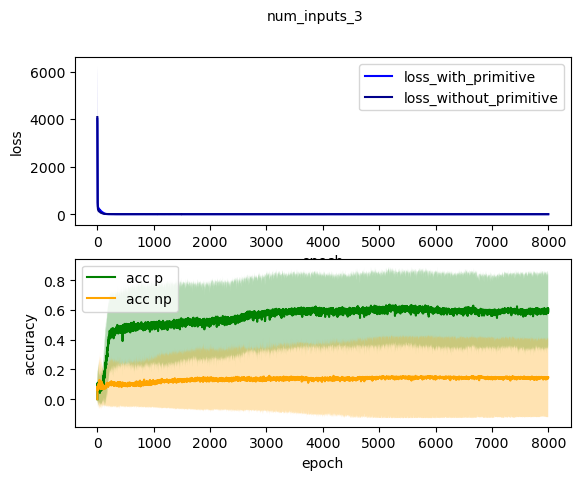

In [49]:
## 5 inputs with primitive training
reses5 = Parallel(n_jobs = -1)(delayed(exp1)(5) for i in range(num_sims))

cuedicts_5 = [r['cue_dict'] for r in reses5]
all_dfs5 = [r['df'] for r in reses5]

all_losses5p = np.hstack([r['losses'] for r in reses5])
all_accs_train5p = np.array([r['accs'][:,0] for r in reses5]).T
all_accs_test5p = np.array([r['accs'][:,1] for r in reses5]).T
all_mods5p = [r['model'] for r in reses5]

all_losses5np = np.hstack([r['losses_np'] for r in reses5])
all_accs_train5np = np.array([r['accs_np'][:,0] for r in reses5]).T
all_accs_test5np = np.array([r['accs_np'][:,1] for r in reses5]).T
all_mods5np = [r['model_np'] for r in reses5]

plotNNs([all_losses5p, all_losses5np], [all_accs_test5p, all_accs_test5np], \
        ['acc p', 'acc np'], colors = ['green', 'orange'], title = 'num_inputs_'+str(3), shift = 0)

In [50]:
## 6 inputs with primitive training
reses6 = Parallel(n_jobs = -1)(delayed(exp1)(6) for i in range(num_sims))

cuedicts_6 = [r['cue_dict'] for r in reses6]
all_dfs6 = [r['df'] for r in reses6]

all_losses6p = np.hstack([r['losses'] for r in reses6])
all_accs_train6p = np.array([r['accs'][:,0] for r in reses6]).T
all_accs_test6p = np.array([r['accs'][:,1] for r in reses6]).T
all_mods6p = [r['model'] for r in reses6]

all_losses6np = np.hstack([r['losses_np'] for r in reses6])
all_accs_train6np = np.array([r['accs_np'][:,0] for r in reses6]).T
all_accs_test6np = np.array([r['accs_np'][:,1] for r in reses6]).T
all_mods6np = [r['model_np'] for r in reses6]

plotNNs([all_losses6p, all_losses6np], [all_accs_test6p, all_accs_test6np], \
        ['acc p', 'acc np'], colors = ['green', 'orange'], title = 'num_inputs_'+str(3), shift = 0)

KeyboardInterrupt: 

In [ ]:
## 7 inputs with primitive training
reses7 = Parallel(n_jobs = -1)(delayed(exp1)(7) for i in range(num_sims))

cuedicts_7 = [r['cue_dict'] for r in reses7]
all_dfs7 = [r['df'] for r in reses7]

all_losses7p = np.hstack([r['losses'] for r in reses7])
all_accs_train7p = np.array([r['accs'][:,0] for r in reses7]).T
all_accs_test7p = np.array([r['accs'][:,1] for r in reses7]).T
all_mods7p = [r['model'] for r in reses7]

all_losses7np = np.hstack([r['losses_np'] for r in reses7])
all_accs_train7np = np.array([r['accs_np'][:,0] for r in reses7]).T
all_accs_test7np = np.array([r['accs_np'][:,1] for r in reses7]).T
all_mods7np = [r['model_np'] for r in reses7]

plotNNs([all_losses7p, all_losses7np], [all_accs_test7p, all_accs_test7np], \
        ['acc p', 'acc np'], colors = ['green', 'orange'], title = 'num_inputs_'+str(3), shift = 0)

In [ ]:
## 8 inputs with primitive training
reses8 = Parallel(n_jobs = -1)(delayed(exp1)(8) for i in range(num_sims))

cuedicts_8 = [r['cue_dict'] for r in reses8]
all_dfs8 = [r['df'] for r in reses8]

all_losses8p = np.hstack([r['losses'] for r in reses8])
all_accs_train8p = np.array([r['accs'][:,0] for r in reses8]).T
all_accs_test8p = np.array([r['accs'][:,1] for r in reses8]).T
all_mods8p = [r['model'] for r in reses8]

all_losses8np = np.hstack([r['losses_np'] for r in reses8])
all_accs_train8np = np.array([r['accs_np'][:,0] for r in reses8]).T
all_accs_test8np = np.array([r['accs_np'][:,1] for r in reses8]).T
all_mods8np = [r['model_np'] for r in reses8]

plotNNs([all_losses8p, all_losses8np], [all_accs_test8p, all_accs_test8np], \
        ['acc p', 'acc np'], colors = ['green', 'orange'], title = 'num_inputs_'+str(3), shift = 0)

Text(0, 0.5, 'prediction')

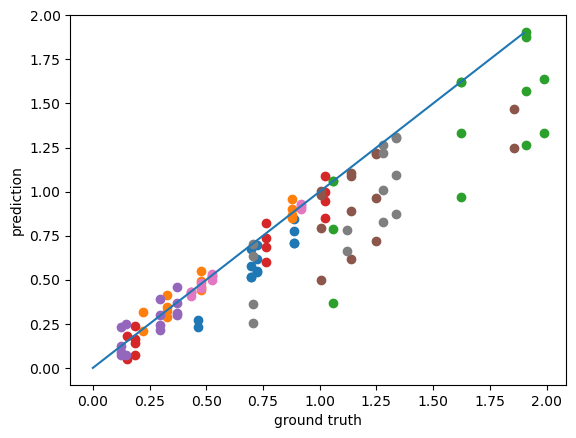

In [93]:
for i in range(num_sims):
    plt.scatter(all_labs4p[:,i], all_preds4p[:,i])
plt.plot(np.arange(0, 2, 0.1), np.arange(0, 2, 0.1))
plt.xlabel('ground truth')
plt.ylabel('prediction')

Text(0, 0.5, 'prediction')

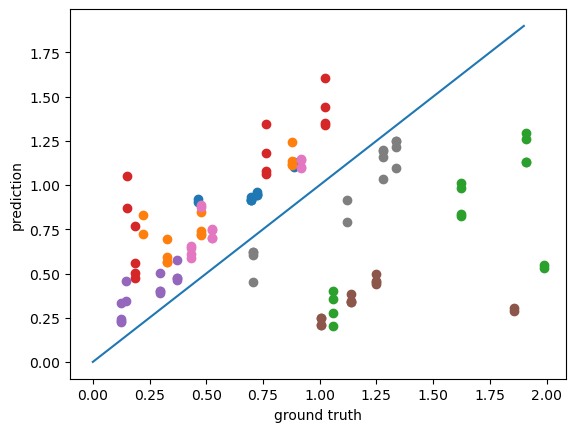

In [92]:
for i in range(num_sims):
    plt.scatter(all_labs4np[:,i], all_preds4np[:,i])
plt.plot(np.arange(0, 2, 0.1), np.arange(0, 2, 0.1))
plt.xlabel('ground truth')
plt.ylabel('prediction')

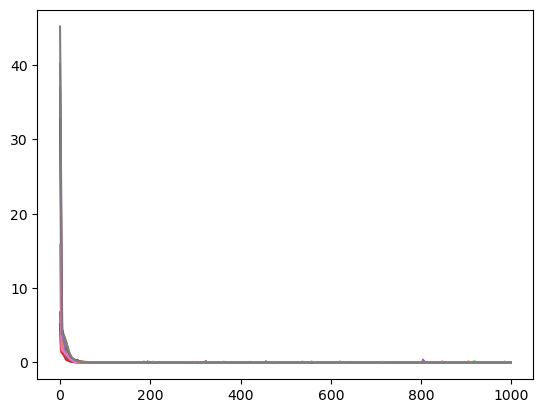

In [39]:
plt.plot(np.array(all_losses4p)[:,:,0].T)

In [24]:
all_losses4p = np.array([r[0][:] for r in reses]).reshape(-1, num_sims)

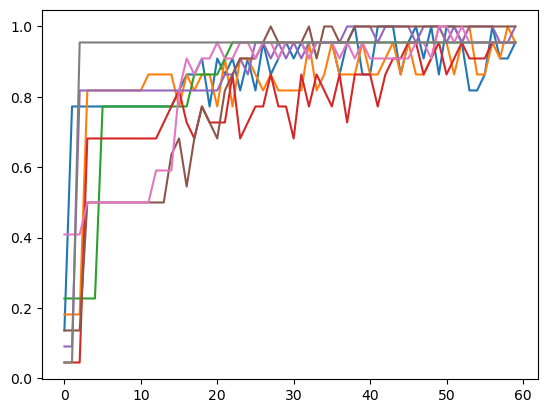

In [27]:
plt.plot(all_accs_train4p)

In [25]:
all_losses4p.shape

(60, 8)

In [19]:
np.array(all_losses4p).T.shape

(1, 60, 8)

In [ ]:
## 3 inputs
reses = Parallel(n_jobs = -1)(delayed(exp1)(3) for i in range(num_sims))
all_losses3 = [r[0] for r in reses]
all_accs_train3 = np.array([r[1][:,0] for r in reses]).T
all_accs_test3 = np.array([r[1][:,1] for r in reses]).T
all_preds3 = [r[2] for r in reses]
all_labs3 = [r[3] for r in reses]
all_mods3 = [r[4] for r in reses]

In [ ]:
## 4 inputs
reses = Parallel(n_jobs = -1)(delayed(exp1)(4) for i in range(num_sims))
all_losses4 = [r[0] for r in reses]
all_accs_train4 = np.array([r[1][:,0] for r in reses]).T
all_accs_test4 = np.array([r[1][:,1] for r in reses]).T
all_preds4 = [r[2] for r in reses]
all_labs4 = [r[3] for r in reses]
all_mods4 = [r[4] for r in reses]

In [ ]:
## 5 inputs
reses = Parallel(n_jobs = -1)(delayed(exp1)(5) for i in range(num_sims))
all_losses5 = [r[0] for r in reses]
all_accs_train5 = np.array([r[1][:,0] for r in reses]).T
all_accs_test5 = np.array([r[1][:,1] for r in reses]).T
all_preds5 = [r[2] for r in reses]
all_labs5 = [r[3] for r in reses]
all_mods5 = [r[4] for r in reses]

In [104]:
num_inputs = 3

In [105]:
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H']
all_syms = total_syms[:num_inputs]

# randomly select values for each input
cue_dict = {}
for s in all_syms:
    cue_dict[s] = random.random()
# generate trials
p = pad_seqs_1step(all_syms, cue_dict)
train_sims = all_syms[1:]
trainseqs = generate_sequences(['+'], train_sims, len_seq = 1, cue_dict = cue_dict, init_values = train_sims)
testseqs = generate_sequences(['+'], all_syms, len_seq = 1, cue_dict = cue_dict, init_values = all_syms)
# remove any trian trials from test set
for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
# load data
padtrain = p + pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(testseqs)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)


In [156]:
for x, y in testset:
    print(onehot2seq(x))

['A', '+', 'C', '+', 'X']
['C', '+', 'X', '+', 'A']
['A', '+', 'X', '+', 'C']
['A', '+', 'B', '+', 'X']
['B', '+', 'A', '+', 'X']
['A', '+', 'A', '+', 'X']
['B', '+', 'X', '+', 'A']
['A', '+', 'X', '+', 'B']
['C', '+', 'A', '+', 'X']
['A', '+', 'X', '+', 'A']


In [111]:
xs[0].shape

torch.Size([1, 5, 14])

In [155]:
def onehot2seq(seqs):
    curr_trial = []
    for seq in seqs:
        for step in seq:
            curr_trial.append(onehot_dict[np.argmax(step).item()])
    
    return curr_trial

    

In [115]:
cue_dict

{'A': 0.24513687242890303, 'B': 0.3451680335140914, 'C': 0.9572471780250557}

In [124]:
convert_inputcue = {'X': 0,
                    'Y': 1,
                    'A': 2, 
                    'B': 3,
                    'C': 4,
                    'D': 5,
                    'E': 6, 
                    'F': 7,
                    'G': 8,
                    'H': 9
                    }

onehot_dict = {0:'X',
                1:'Y',
                2:'A', 
                3:'B',
                4:'C',
                5:'D',
                6:'E', 
                7:'F',
                8:'G',
                9:'H',
               10:'+',
               11:'*',
               12:'-',
               13:'%',
                    }

In [123]:
onehot_dict[0]

'X'

In [119]:
convert_inputcue.get(0)